In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import math
os.getcwd()
plt.style.use('ggplot')
import numba
import datetime

In [9]:
#true price jump rate (assume there exists a true price to the underlying, which
#                      is different than the market price, which follows a poisson process)
lambda_p = .225

#uninformed rate (for those with only public information, they randomly place orders)
lambda_u = .225

#informed rate (for those with superior knowledge, they know true price they buy
#               and sell against the market maker if there is edge)
lambda_i = .1

#2*lambda_p + 2*lambda_u +lambda_i = 1 (Since an event in the market has to occur)
#Essentially all possible market events when there are informed traders
lambdas = np.cumsum([lambda_p,lambda_p,lambda_u,lambda_u+lambda_i])

#Essentially all possible market events when there are not informed traders
lambdas_0 = np.cumsum([lambda_p,lambda_p,lambda_u,lambda_u])

#Uniform Random Numbers that indicate which market event occured
U = np.random.uniform(0,2*lambda_p+2*lambda_u+lambda_i)  
U_0 = np.random.uniform(0,2*lambda_p+2*lambda_u)  


In [11]:
#See diagram on page 19 of MIT article 
#This function gives a state transition in that markov chain 
#With vector x, we can record if a buy or sell order occured


#i: difference between true price and mm price 
#j: order imbalance 
#State is made up of (i,j)
#U: Random number between 0 and 2*lambda_p+2*lambda_u+lambda_i
#   to denote market event when there are informed traders
#U_0: Random number between 0 and 2*lambda_p+2*lambda_u
#     to denote market event when there is no informed traders
#m: threshhold imbalance at which market maker changes price (instead of immediately doing it)

@numba.jit(nopython=True)
def s_next(i,j,U,U_0,m):
    
    # [1,0] means buy order arrives, [0,1] sell order
    x = np.zeros( (2,1) )

    # quoted price = true price so no arrival of informed 
    if i==0:
        #Determine which event happened and update state accordingly
        if U_0<lambdas_0[0]:
            i+=1
        elif U_0<lambdas_0[1]:
            i-=1
        elif U_0<lambdas_0[2]:
            if m-j==1:
                j-=1
                x[1] = 1 
            else:
                j+=1
                x[0] = 1
        else:
            if m-j==1:
                i+=1
                j-=1
                x[0] = 1
                
            elif -m-j==-1:
                i-=1
                j+=1
                x[1] = 1 
            else:
                j-=1
                x[1] = 1 
    
    #informed arrives
    else:
        #Determine which event happened and update state accordingly
        if U < lambdas[0]:
            i+=1
        elif U < lambdas[1]:
            i-=1
        #the non-ideal trade (As we are facing the informed)
        elif U < lambdas[2]:
            if i<0:
                if -m-j == -1:
                    i-=1
                    j+=1
                else:
                    j-=1
                    
                x[1] = 1 
            else:
                if m-j == 1:
                    i+=1
                    j-=1
                else:
                    j+=1
                x[0] = 1
                
        #the ideal trade
        else:
            if i<0:
                if m-j == 1:
                    i+=1
                    j-=1
                else:
                    j+=1
                x[0] = 1 
            else:
                if -m-j == -1:
                    i-=1
                    j+=1
                else:
                    j-=1
                
                x[1] = 1 


    return (i,j,x)



In [12]:
period_size=100
#Function will output reward vector and cumulative sum of rewards accumulated over period
#Reward is defined as equation 11 on pg 22 of paper  

#@numba.jit(nopython=True)
def simulate(m,period_size):
  
    i=0
    j=0
      
    #reward vector
    R = []
    
    for k in range(period_size):
    
        U = np.random.uniform(0,2*lambda_p+2*lambda_u+lambda_i)  
        U_0 = np.random.uniform(0,2*lambda_p+2*lambda_u)

        i_new,j_new,x = s_next(i,j,U,U_0,m)
        
        #if buy order arrived
        if x[0] == 1:
            R.append(-1*i_new)
        
        #if sell order arrived 
        elif x[1] == 1:
            R.append(i_new)
        
        i = i_new
        j = j_new
    
    R = np.array(R)
    R_cs = np.cumsum(R)
    
    return R,R_cs

alpha = 1
sum 1.0000000000000002
mean :16.622
standard dev :27.544747521079223


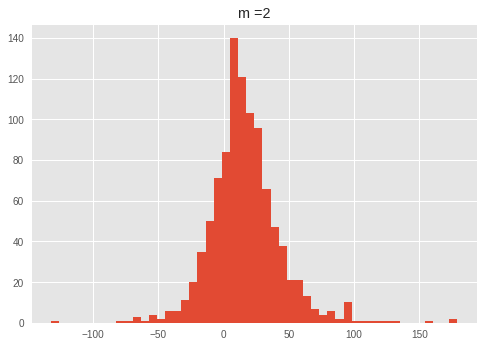

mean :20.0975
standard dev :28.981045421965025


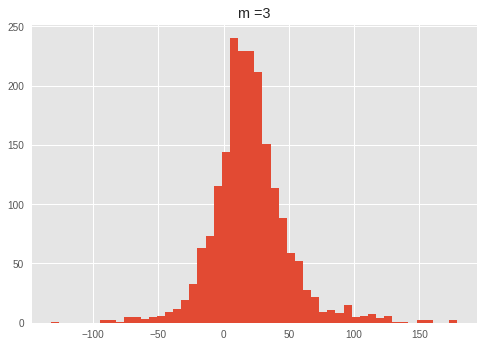

mean :22.032666666666668
standard dev :29.574689621739434


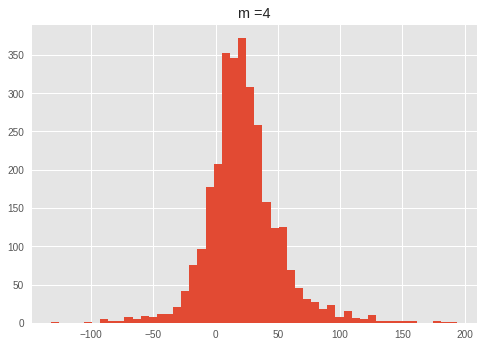

mean :23.78325
standard dev :29.934132181132295


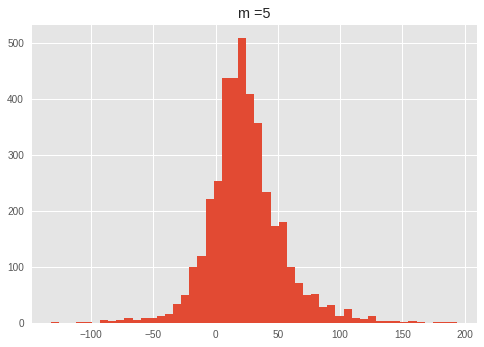

mean :24.7954
standard dev :30.383810472684296


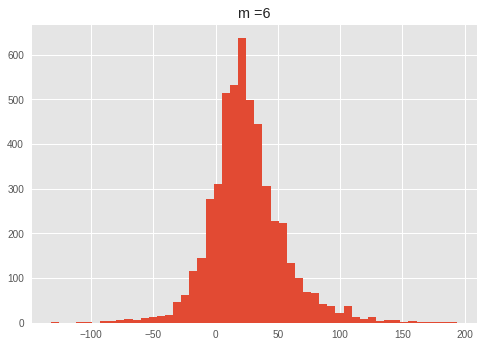

mean :25.506833333333333
standard dev :30.588804378490433


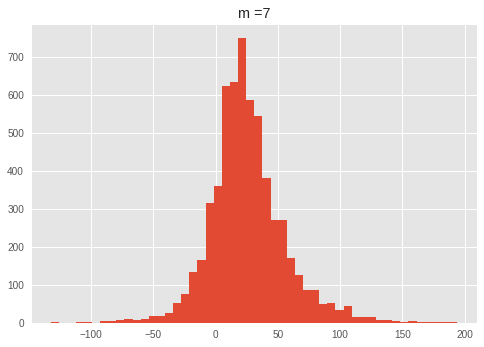

mean :26.303285714285714
standard dev :30.861314490170773


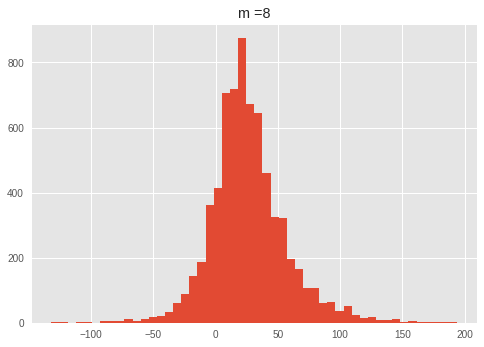

mean :26.99
standard dev :31.329832428533674


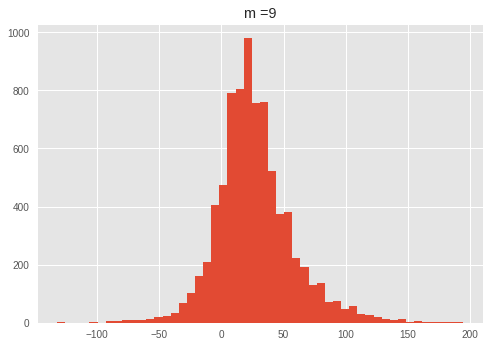

alpha = 2
sum 1.0
mean :16.916
standard dev :28.358225332344055


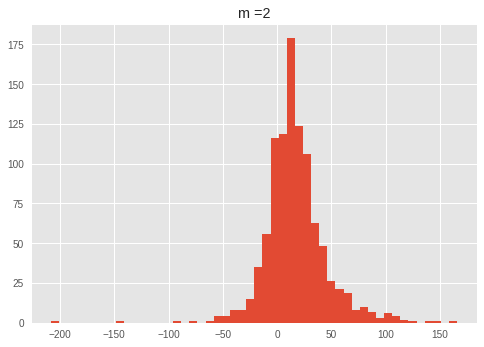

mean :19.5685
standard dev :28.404529704784764


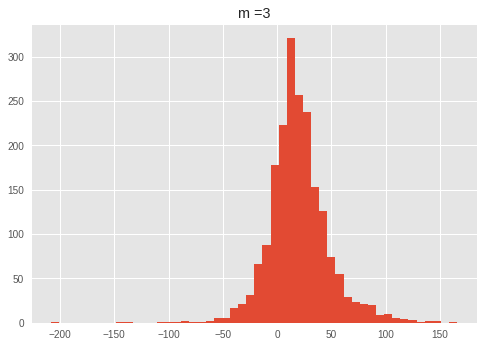

mean :21.720666666666666
standard dev :28.213046146931546


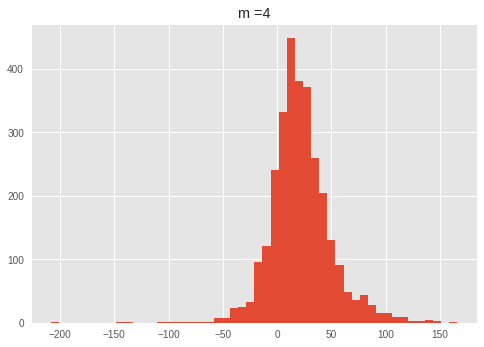

mean :22.89725
standard dev :29.03332899337415


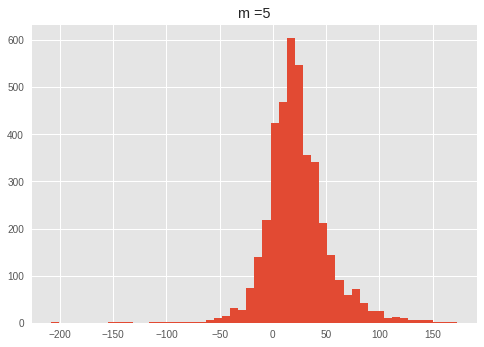

mean :24.1722
standard dev :29.857423652418504


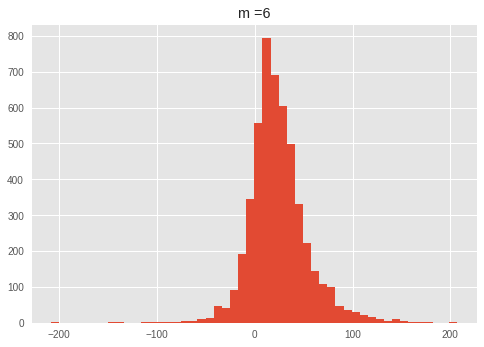

mean :25.0915
standard dev :30.914329920227395


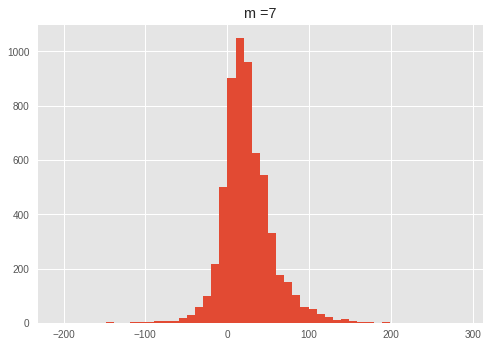

mean :25.93285714285714
standard dev :31.59745569064777


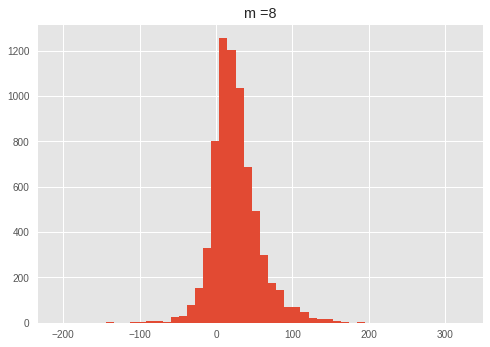

mean :26.698
standard dev :32.076569267925144


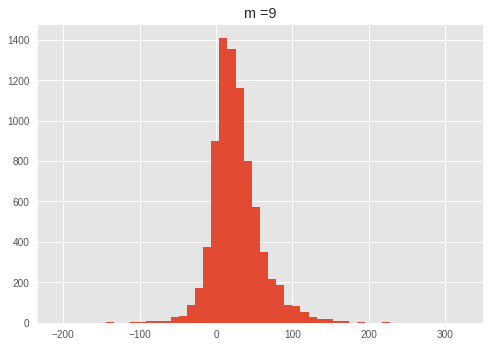

alpha = 3
sum 1.0
mean :15.362
standard dev :27.12738387681348


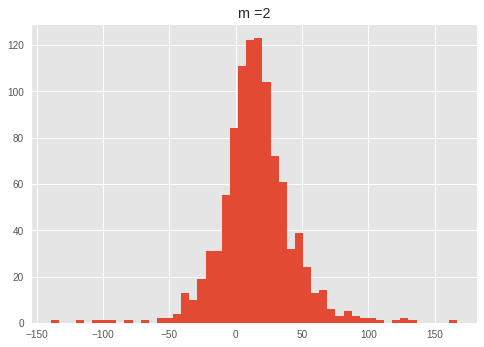

mean :19.3155
standard dev :28.784057388596207


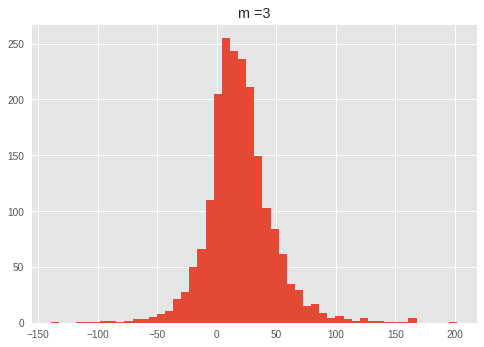

mean :21.582
standard dev :28.9839370916605


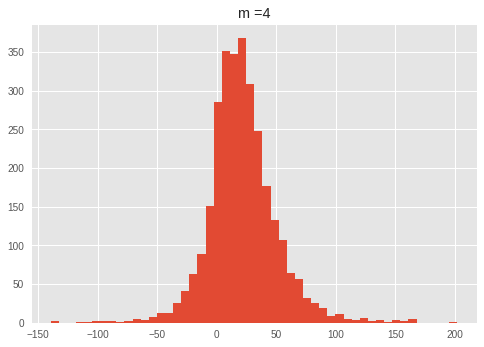

mean :23.4105
standard dev :29.51320026276378


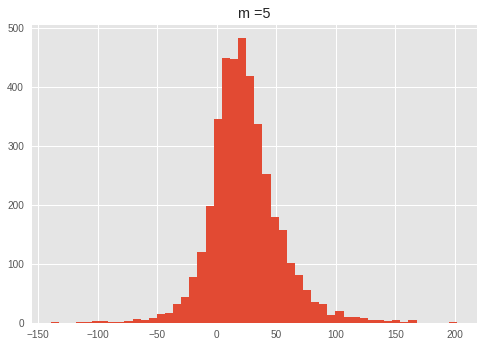

mean :24.6518
standard dev :30.43656611314752


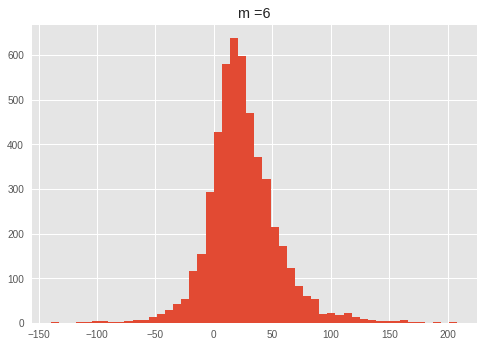

mean :25.646833333333333
standard dev :31.338971052650866


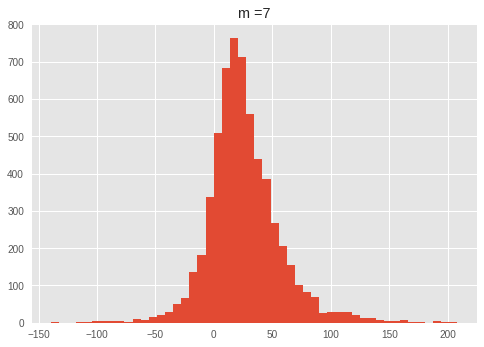

mean :26.611
standard dev :31.91624698891057


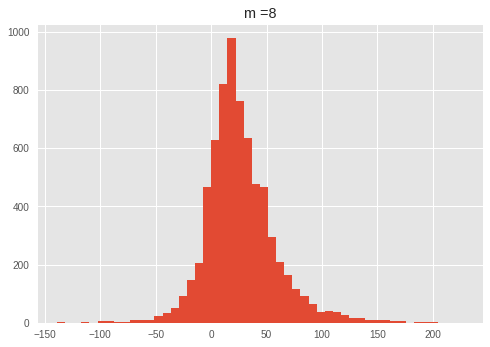

mean :27.045375
standard dev :32.21551747387235


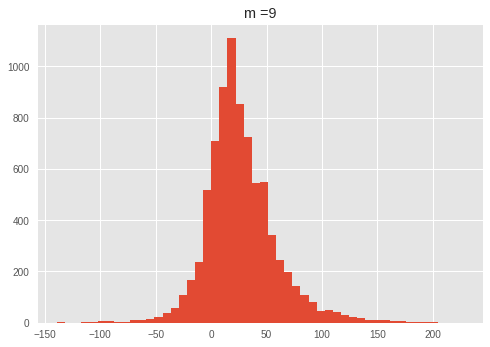

alpha = 4
sum 1.0
mean :17.872
standard dev :28.78280069763886


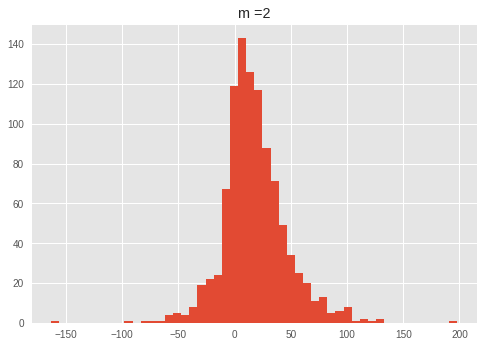

mean :21.057
standard dev :28.847699232347804


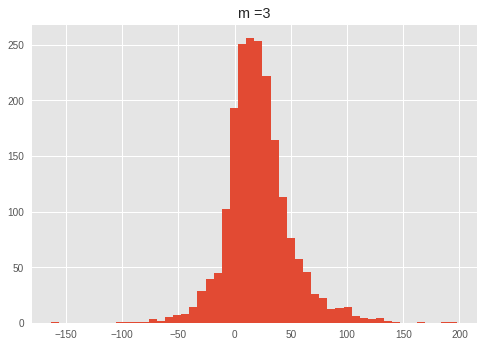

mean :23.382666666666665
standard dev :29.323907758384152


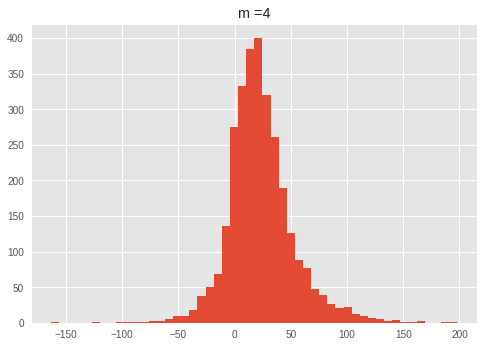

mean :24.024
standard dev :29.583583690959415


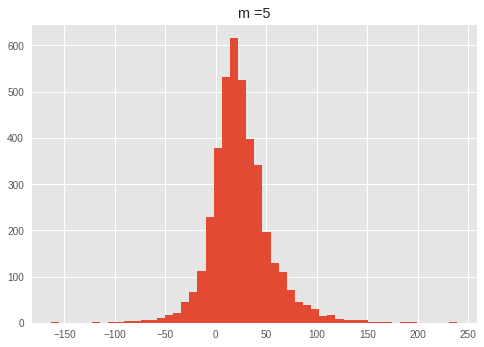

mean :25.0322
standard dev :30.329602093664203


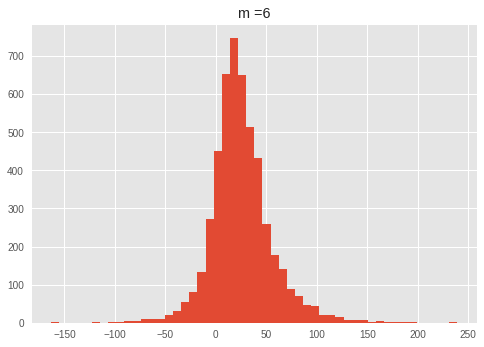

mean :25.915166666666668
standard dev :31.3855322822298


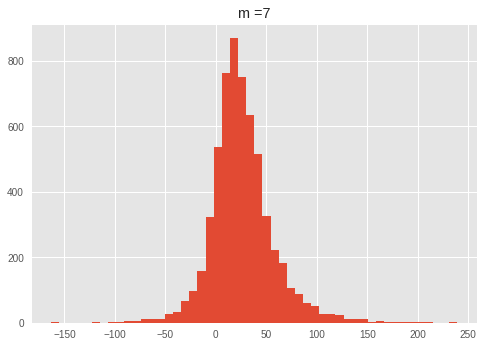

mean :26.801285714285715
standard dev :31.960088030516552


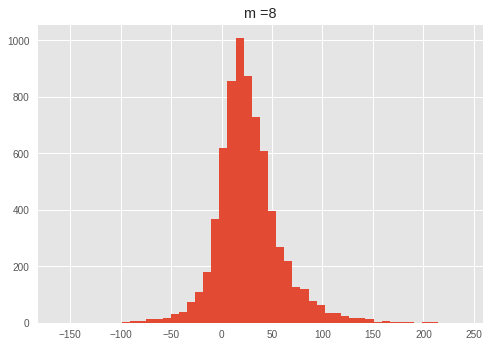

mean :27.260375
standard dev :32.33540752579709


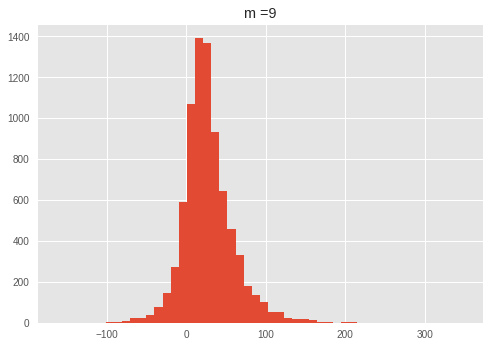

alpha = 5
sum 1.0
mean :16.166
standard dev :30.390861192141298


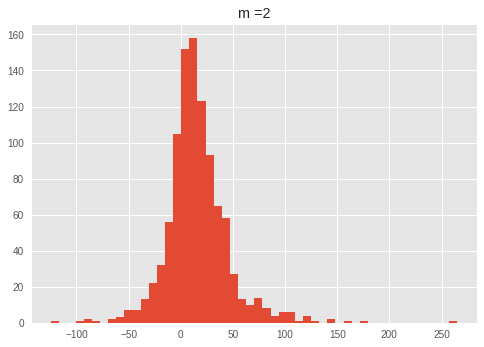

mean :20.319
standard dev :30.61952382059525


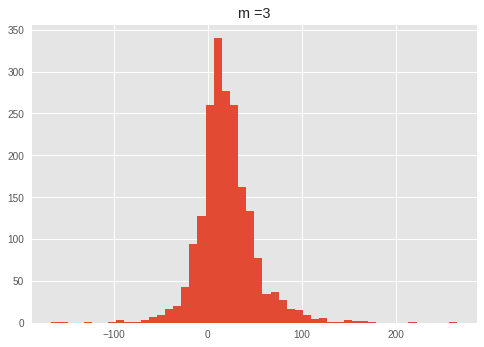

mean :22.682333333333332
standard dev :30.7148078493456


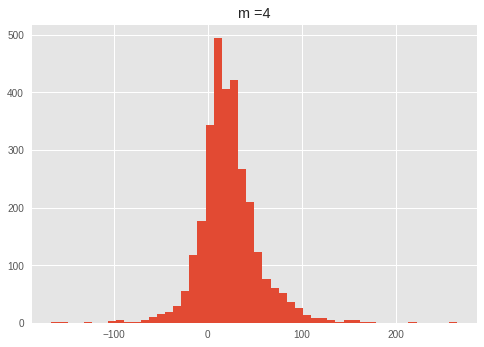

mean :23.78425
standard dev :31.21892377929611


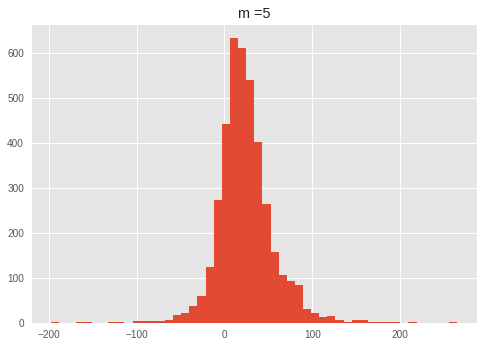

mean :24.9274
standard dev :31.617288454894418


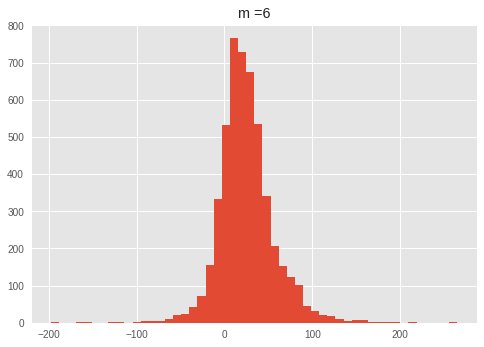

mean :25.6405
standard dev :31.67115290633839


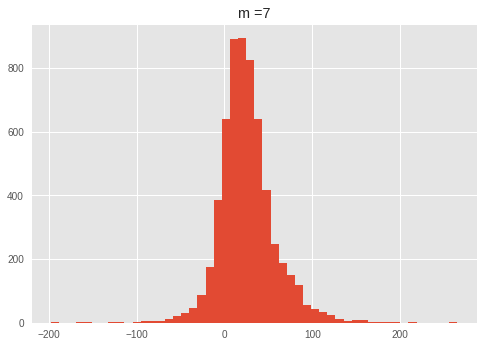

mean :26.518285714285714
standard dev :31.850565501659627


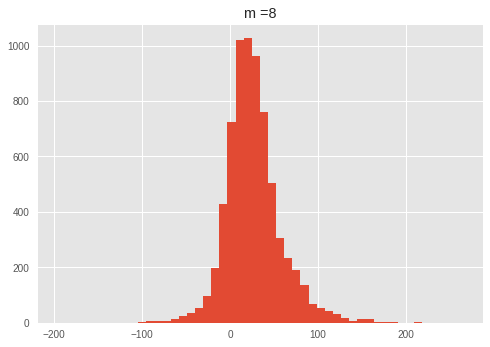

mean :27.215
standard dev :32.15814476924936


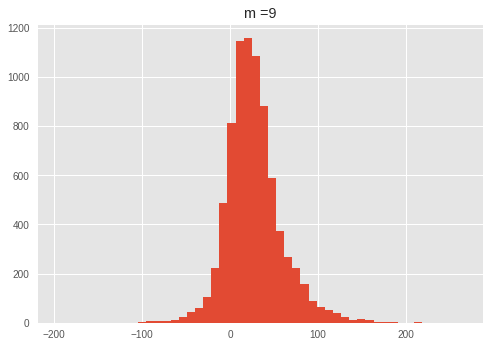

alpha = 6
sum 1.0
mean :15.805
standard dev :29.73484445898448


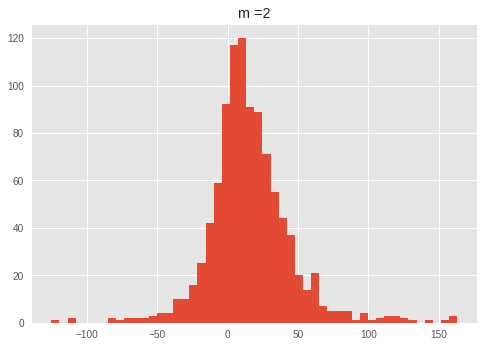

mean :19.599
standard dev :31.440597942787285


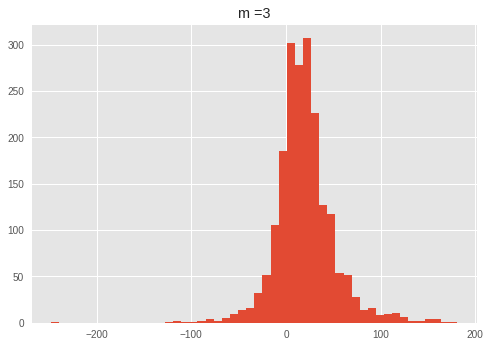

mean :22.387
standard dev :31.185390238593026


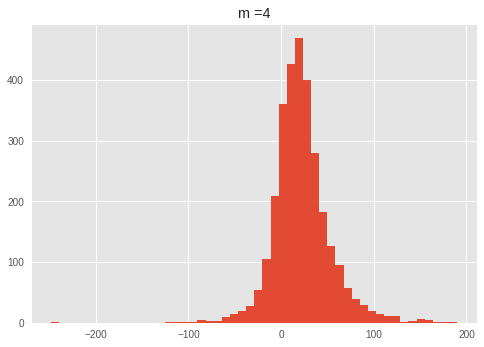

mean :23.96
standard dev :31.103125244901033


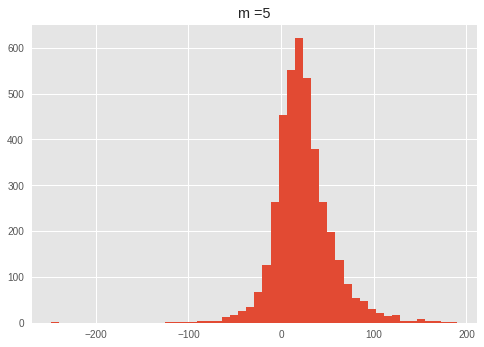

mean :25.0936
standard dev :31.70813837234851


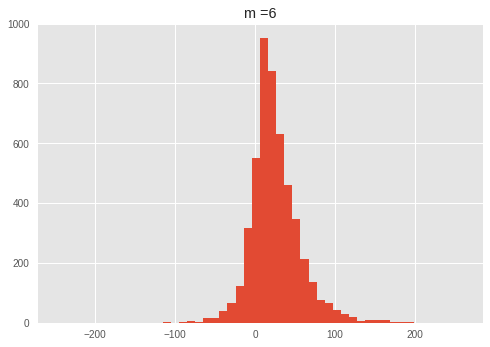

mean :26.302333333333333
standard dev :32.119006749206235


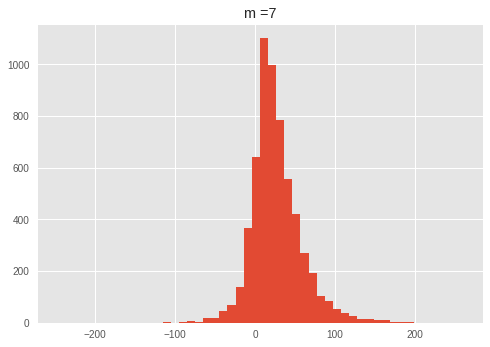

mean :27.013857142857145
standard dev :32.64088508922764


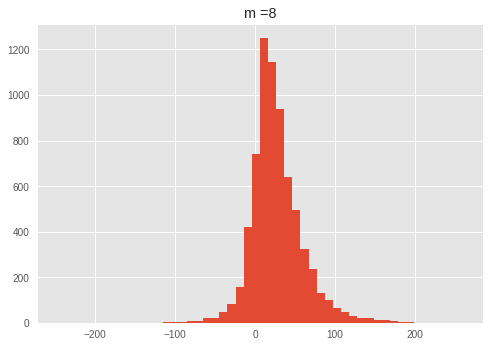

mean :27.65875
standard dev :33.02906747756436


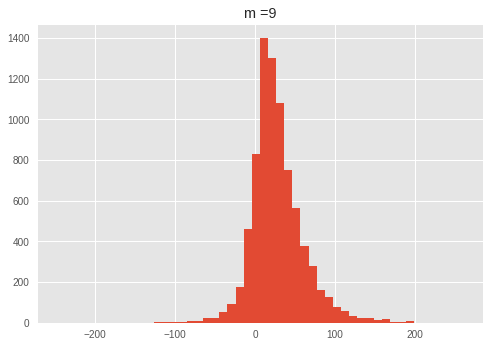

In [13]:
for alpha in range(1,7):

    print('alpha = '+str(alpha))
    #true price jump rate
    lambda_p = .225

    #uninformed rate
    lambda_u = .225

    #informed rate
    lambda_i = .1

    lambda_p = lambda_p/alpha
    lambda_u =  (1 - 2*lambda_p - lambda_i)/2
    print('sum '+str(2*lambda_p + 2*lambda_u +lambda_i))

    #2*lambda_p + 2*lambda_u +lambda_i = 1
    lambdas = np.cumsum([lambda_p,lambda_p,lambda_u,lambda_u+lambda_i])

    lambdas_0 = np.cumsum([lambda_p,lambda_p,lambda_u,lambda_u])

    U = np.random.uniform(0,2*lambda_p+2*lambda_u+lambda_i)  
    U_0 = np.random.uniform(0,2*lambda_p+2*lambda_u)  

    #now test strategy with different threshold value of m 
    #see page 18 of paper for detail

    num_iterations = 1000
    avg_final_wealth = []
    for m in range(2,10):
        for a in range(num_iterations):
            R,R_cs = simulate(m,period_size)
            final_wealth = R_cs[-1]
            avg_final_wealth.append(final_wealth)


        plt.hist(avg_final_wealth,bins=50)
        plt.title('m ='+str(m))
        print('mean :'+str(np.mean(np.array(avg_final_wealth))))
        print('standard dev :'+str(np.std(np.array(avg_final_wealth))))
        plt.show()